In [ ]:
!pip install numpy pandas scikit-learn xgboost shap matplotlib seaborn




In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
import xgboost as xgb
import shap
import os

In [ ]:
import kagglehub
import pandas as pd
import os

# Download latest version
path = kagglehub.dataset_download("uciml/pima-indians-diabetes-database")

print("Path to dataset files:", path)

# Find the CSV file inside the path
for file in os.listdir(path):
    if file.endswith(".csv"):
        dataset_path = os.path.join(path, file)
        break

# Load dataset into pandas
df = pd.read_csv(dataset_path)
print("Shape of dataset:", df.shape)
print(df.head())


Path to dataset files: /kaggle/input/pima-indians-diabetes-database
Shape of dataset: (768, 9)
   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1  


In [ ]:
# 3.1 Missing values handling:
cols_with_zero_missing = ["Glucose","BloodPressure","SkinThickness","Insulin","BMI"]
for col in cols_with_zero_missing:
    df[col] = df[col].replace(0, np.nan)

print("Missing values per column:")
print(df.isna().sum())


Missing values per column:
Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64


In [ ]:
# 3.2 Median imputation
for col in cols_with_zero_missing:
    df[col].fillna(df[col].median(), inplace=True)

# 3.3 Feature/target split
X = df.drop(columns=["Outcome"])
y = df["Outcome"]


/tmp/ipython-input-1051695520.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].median(), inplace=True)


In [ ]:
#  4. Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)
print("Train/test sizes:", X_train.shape, X_test.shape)

Train/test sizes: (614, 8) (154, 8)


In [ ]:
#  5. Model Training
# 5A RandomForest
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)

# 5B XGBoost
xgb_model = xgb.XGBClassifier(
    use_label_encoder=False, eval_metric='logloss',
    random_state=42, n_estimators=200
)
xgb_model.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:01:06] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, ...)


--- Random Forest ---
Accuracy: 0.7403
Precision: 0.6522
Recall: 0.5556
F1-score: 0.6
ROC AUC: 0.8161
              precision    recall  f1-score   support

           0       0.78      0.84      0.81       100
           1       0.65      0.56      0.60        54

    accuracy                           0.74       154
   macro avg       0.71      0.70      0.70       154
weighted avg       0.73      0.74      0.73       154



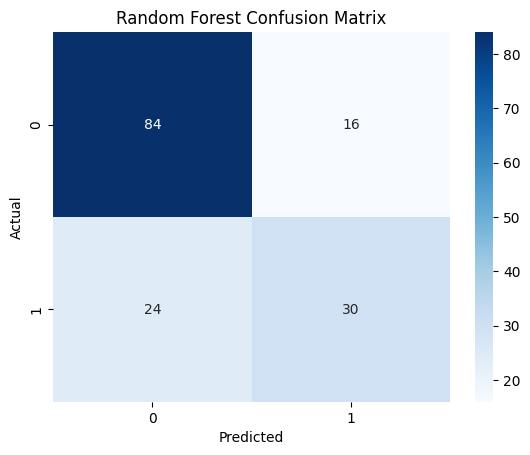


--- XGBoost ---
Accuracy: 0.7532
Precision: 0.66
Recall: 0.6111
F1-score: 0.6346
ROC AUC: 0.8041
              precision    recall  f1-score   support

           0       0.80      0.83      0.81       100
           1       0.66      0.61      0.63        54

    accuracy                           0.75       154
   macro avg       0.73      0.72      0.72       154
weighted avg       0.75      0.75      0.75       154



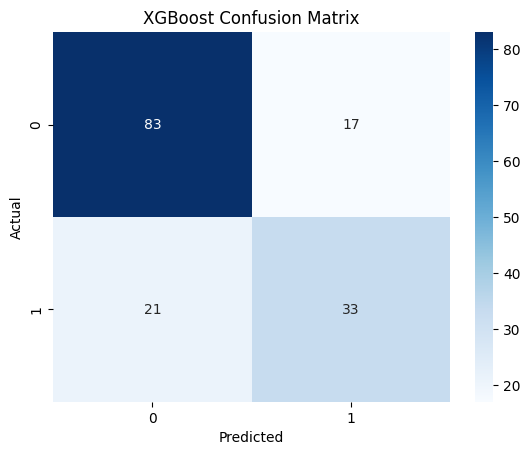

In [ ]:
#  6. Evaluation
def evaluate_model(model, X_test, y_test, name="Model"):
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:,1] if hasattr(model, "predict_proba") else None
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc = roc_auc_score(y_test, y_prob) if y_prob is not None else None

    print(f"\n--- {name} ---")
    print("Accuracy:", round(acc,4))
    print("Precision:", round(prec,4))
    print("Recall:", round(rec,4))
    print("F1-score:", round(f1,4))
    if roc is not None:
        print("ROC AUC:", round(roc,4))
    print(classification_report(y_test, y_pred))

    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"{name} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

evaluate_model(rf, X_test, y_test, "Random Forest")
evaluate_model(xgb_model, X_test, y_test, "XGBoost")

In [ ]:
# Choose explainer model (use XGBoost here; switch to rf if it performs better)
explainer_model = xgb_model

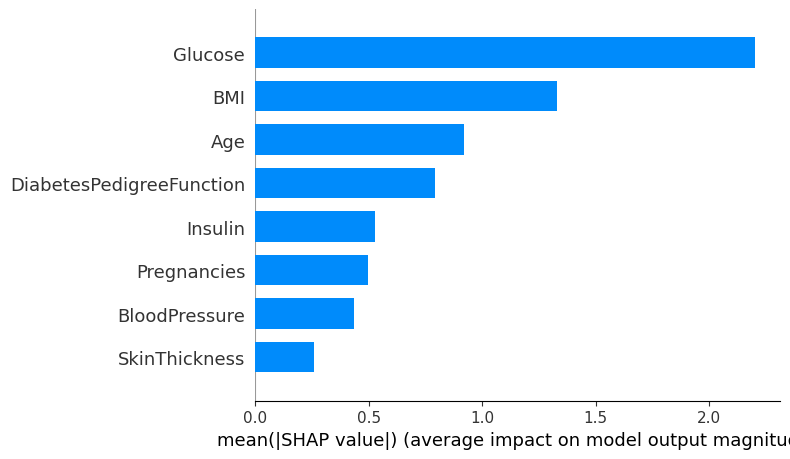

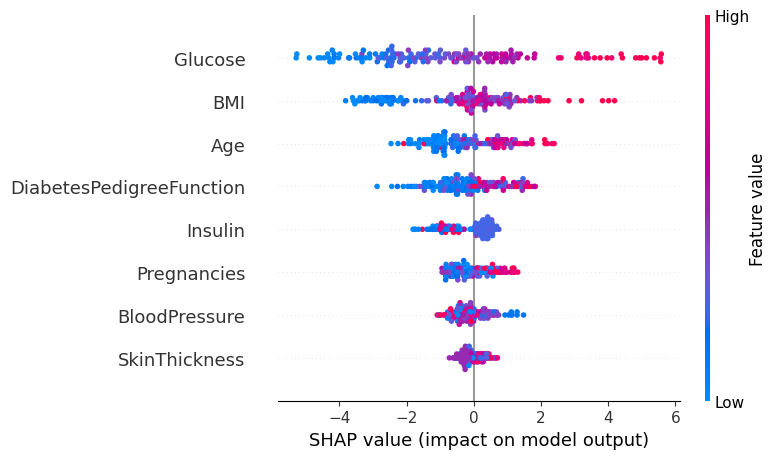

Actual label: 0
Predicted prob: 0.9711816


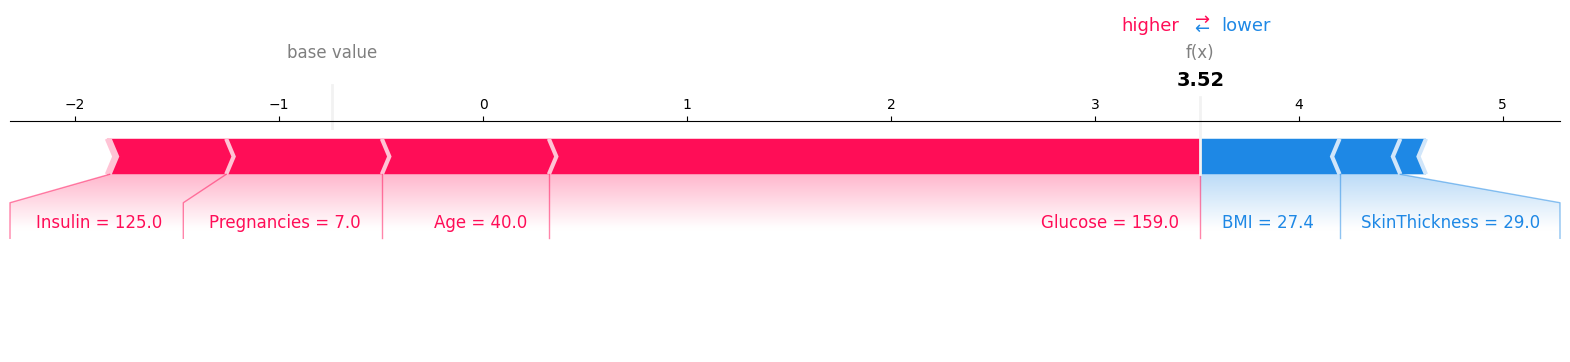

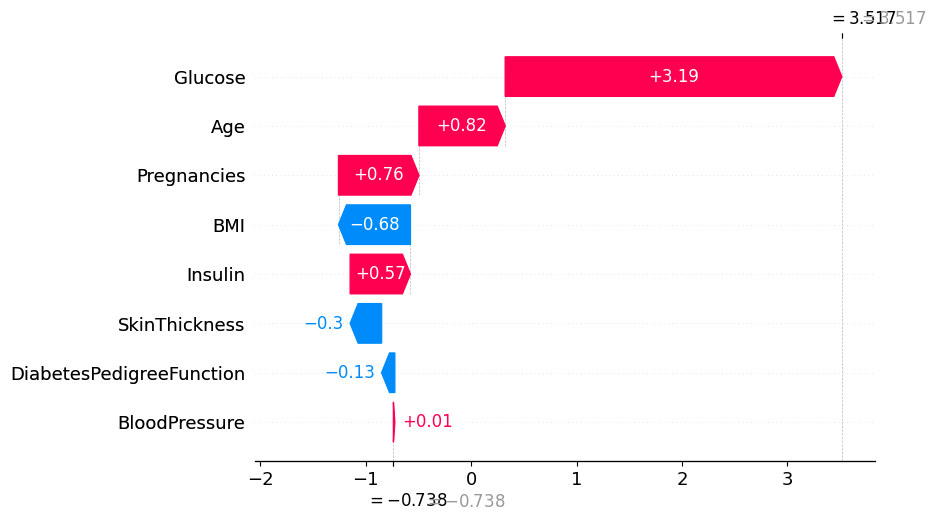

In [ ]:
#  7. SHAP Analysis
shap.initjs()
explainer = shap.TreeExplainer(explainer_model)
shap_values = explainer.shap_values(X_test)

# 7.1 Summary plots
plt.figure()
shap.summary_plot(shap_values, X_test, plot_type="bar", show=True)
shap.summary_plot(shap_values, X_test, show=True)

# 7.2 Force plot for one sample
i = 0
print("Actual label:", y_test.iloc[i])
print("Predicted prob:", explainer_model.predict_proba(X_test.iloc[[i]])[0,1])
shap.force_plot(explainer.expected_value, shap_values[i,:], X_test.iloc[i,:], matplotlib=True)

# 7.3 Waterfall plot
shap.plots._waterfall.waterfall_legacy(
    explainer.expected_value, shap_values[i,:], feature_names=X_test.columns
)

In [ ]:
#  8. Compare Importances
try:
    built_in = explainer_model.feature_importances_
    fi = pd.Series(built_in, index=X_test.columns).sort_values(ascending=False)
    print("\nBuilt-in feature importance (top 10):")
    print(fi.head(10))

    shap_rank = pd.Series(np.abs(shap_values).mean(axis=0), index=X_test.columns).sort_values(ascending=False)
    print("\nSHAP mean(|value|) top 10:")
    print(shap_rank.head(10))
except Exception as e:
    print("Could not get built-in importances:", e)


Built-in feature importance (top 10):
Glucose                     0.253411
BMI                         0.138287
Insulin                     0.130277
Age                         0.117147
Pregnancies                 0.105294
DiabetesPedigreeFunction    0.087286
BloodPressure               0.085730
SkinThickness               0.082568
dtype: float32

SHAP mean(|value|) top 10:
Glucose                     2.200969
BMI                         1.327510
Age                         0.918798
DiabetesPedigreeFunction    0.792523
Insulin                     0.530201
Pregnancies                 0.498348
BloodPressure               0.435429
SkinThickness               0.258260
dtype: float32


In [ ]:
# 9. Top-5 SHAP Feature
shap_importance = pd.Series(np.abs(shap_values).mean(axis=0), index=X_test.columns).sort_values(ascending=False)
top5 = shap_importance.head(5)
print("\nTop-5 SHAP features:")
print(top5)

for feat in top5.index:
    vals = X_test[feat]
    corr = np.corrcoef(vals, shap_values[:, X_test.columns.get_loc(feat)])[0,1]
    print(f"Feature: {feat}, correlation between value and SHAP: {corr:.3f}")



Top-5 SHAP features:
Glucose                     2.200969
BMI                         1.327510
Age                         0.918798
DiabetesPedigreeFunction    0.792523
Insulin                     0.530201
dtype: float32
Feature: Glucose, correlation between value and SHAP: 0.944
Feature: BMI, correlation between value and SHAP: 0.796
Feature: Age, correlation between value and SHAP: 0.637
Feature: DiabetesPedigreeFunction, correlation between value and SHAP: 0.509
Feature: Insulin, correlation between value and SHAP: -0.178



Completed. Check saved files: shap_summary_bar.png, shap_feature_importance.csv


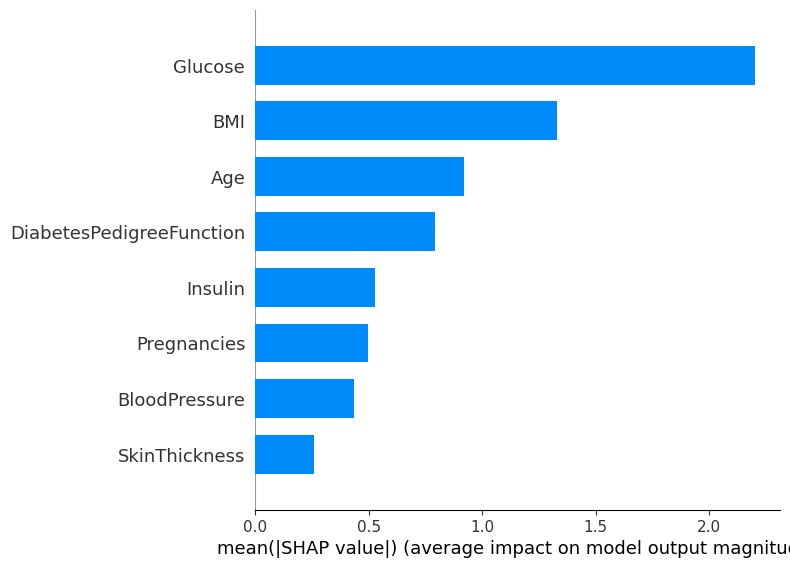

In [ ]:
#  10. Save Outputs
# Save SHAP summary bar plot
plt.figure()
shap.summary_plot(shap_values, X_test, plot_type="bar", show=False)
plt.gcf().set_size_inches(8,6)
plt.savefig("shap_summary_bar.png", bbox_inches='tight')

# Save feature importance CSV
shap_importance.to_csv("shap_feature_importance.csv")

print("\nCompleted. Check saved files: shap_summary_bar.png, shap_feature_importance.csv")